In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 학습 데이터와 테스트 데이터를 비율을 지정해서 무작위로 분리하기 위해 import 한다.
from sklearn.model_selection import train_test_split
# 교차 검증을 실행하기 위해서 import 한다.
from sklearn.model_selection import cross_val_score
# kNN 분류기를 사용하기 위한 KNeighborsClassifier 객체를 import 한다.
from sklearn.neighbors import KNeighborsClassifier
# 모델의 정확도를 계산하기 위해 import 한다.
from sklearn.metrics import accuracy_score

데이터 획득

In [3]:
# Player(선수 이름), Pos(포지션), 3P(3점슛), 2P(2점슛), TRB(리바운드), AST(어시스트), STL(스틸), BLK(블록슛)
df = pd.read_csv('./data/basketball_stat.csv')
df

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5
...,...,...,...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,6.1,10.4,2.8,1.0,1.0
96,Dwyane Wade,SG,0.8,6.2,4.5,3.8,1.4,0.7
97,Dion Waiters,SG,1.8,4.3,3.3,4.3,0.9,0.4
98,Hassan Whiteside,C,0.0,7.0,14.1,0.7,0.7,2.1


In [4]:
df.Pos.value_counts()

C     50
SG    50
Name: Pos, dtype: int64

데이터 시각화

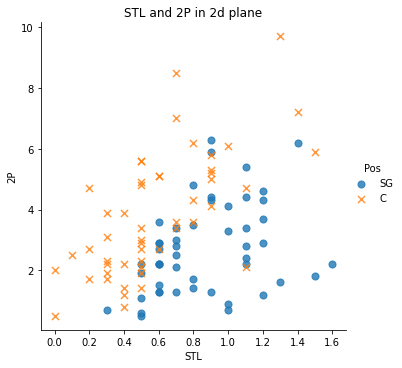

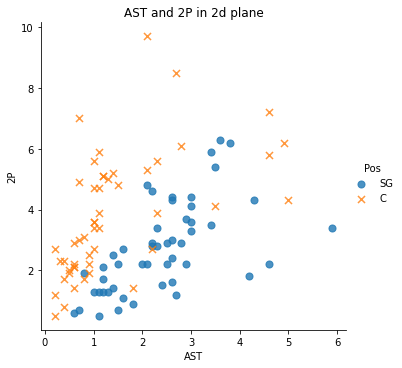

In [5]:
# STL(스틸)과 2P(2점슛), AST(어시스트)와 2P(2점슛)의 Pos(포지션) 별 분포도를 출력한다.
sns.lmplot(
    data=df, x='STL', y='2P', fit_reg=False, # 데이터, x축, y축, 회귀선 표시 여부
    hue='Pos', # 그래프에 표시될 표식의 색상
    scatter_kws={'s': 50}, # 그래프에 표시될 표식의 크기
    markers=['o', 'x'] # 그래프에 표시될 표식의 종류
)
plt.title('STL and 2P in 2d plane')
sns.lmplot(data=df, x='AST', y='2P', fit_reg=False, hue='Pos', scatter_kws={'s': 50}, markers=['o', 'x'])
plt.title('AST and 2P in 2d plane')
plt.show()

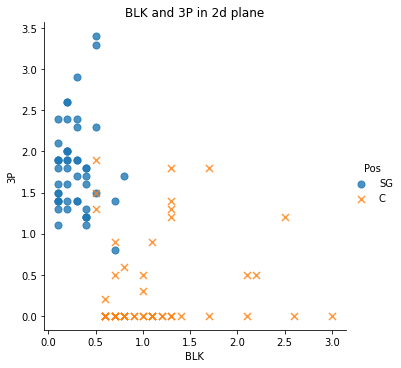

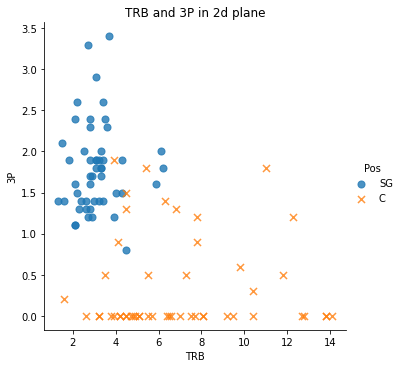

In [6]:
# BLK(블로킹)과 3P(3점슛), TRB(리바운드)와 3P(3점슛)의 Pos(포지션) 별 분포도를 출력한다.
sns.lmplot(data=df, x='BLK', y='3P', fit_reg=False, hue='Pos', scatter_kws={'s': 50}, markers=['o', 'x'])
plt.title('BLK and 3P in 2d plane')
sns.lmplot(data=df, x='TRB', y='3P', fit_reg=False, hue='Pos', scatter_kws={'s': 50}, markers=['o', 'x'])
plt.title('TRB and 3P in 2d plane')
plt.show()

데이터 전처리

In [7]:
# 판다스의 drop() 메소드로 불필요한 컬럼(피쳐)를 삭제한다.
# axis 속성은 생략시 0이 기본값이며 행 단위로 삭제를 하고 1로 지정하면 열 단위로 삭제한다.
# df = df.drop(['2P', 'AST', 'STL'], axis=1)
# inplace 속성은 생략시 False가 기본값이며 실행한 결과를 반영하지 않고 True를 쓰면 실행 결과를 즉시 반영한다.
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


학습(train) 데이터와 테스트(test) 데이터로 나누기

In [8]:
# train_test_split() 메소드는 학습 데이터와 테스트 데이터를 지정한 비율로 나누는 기능을 실행하고 학습 데이터와
# 테스트 데이터의 비율을 지정하지 않으면 학습 데이터 75%, 테스트 데이터 25% 비율로 데이터를 나눈다.
# train_test_split(데이터, train_size, test_size)
# train_size 옵션으로 학습 데이터의 비율을 지정한다.
# test_size 옵션으로 테스트 데이터의 비율을 지정한다.
# 데이터의 80%를 학습용 데이터로 데이터의 20%를 테스트 데이터로 사용한다.
train, test = train_test_split(df, train_size=0.8, test_size=0.2)
print(train.shape[0], test.shape[0])

80 20


최적의 kNN 파라미터 찾기

sklearn 라이브러리의 cross_val_score() 메소드로 k-fold 교차 검증을 사용해서 kNN 알고리즘의 조절 가능한 단 하나의 변수값 k를 찾는다.  
k-fold 교차 검증은 기존 데이터를 k개로 나눠서 k번 정확도를 검증하는 방법이다.

<img src="./images/k-fold.png" align="left" width="700"/>

In [9]:
# 최적의 k를 찾기위해 교차 검증을 수행할 k의 범위를 3부터 학습 데이터 개수의 절반까지 홀수로 저장한다.
k_list = []
for i in range(3, train.shape[0] // 2, 2):
    k_list.append(i)
print(k_list)

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


In [10]:
# 각각의 k별 10-fold 교차 검증 결과의 평균을 기억할 빈 리스트를 선언한다.
cross_validation_scores = []
# train_test_split() 메소드로 분리한 학습 데이터에서 학습에 사용할 데이터(피쳐)를 저장한다.
x_train = train[['3P', 'TRB', 'BLK']]
# train_test_split() 메소드로 분리한 학습 데이터에서 학습 결과로 사용할 데이터(실제값, 레이블, 타겟)를 저장한다.
y_train = train['Pos']

10-fold 교차 검증

학습 데이터를 10개의 조각으로 나누고 1조각을 검증 데이터로 사용하고 나머지 9조각을 학습 데이터로 사용해 1번째 조각부터 10번째 조각까지 1번씩 검증하고 10번의 검증 결과를 10으로 나눈 평균값을 검증 결과 점수로 한다.

cross_val_score(model, X, Y, scoring=None, cv=None)  
model: 분석 모델  
X: 독립 변수, 학습 데이터(피쳐)  
Y: 종속 변수, 학습 결과(실제값, 레이블, 타겟)  
scoring: 성능 검증에 사용할 평가 지표를 지정한다. => 정확도를 의미하는 'accuracy'를 지정한다.  
cv: 교차 검증 생성기 객체 또는 숫자, None이면 KFold(3), 숫자를 지정하면 KFold(숫자)

In [11]:
# 10-fold 교차 검증을 각 k값을 대상으로 실행해서 검증 결과를 저장한다.
for k in k_list[:]:
    # KNeighborsClassifier 객체의 n_neighbors 속성에 kNN 모델에서 사용할 이웃의 개수를 지정해서 모델을 만든다.
    knn = KNeighborsClassifier(n_neighbors=k)
    # 학습에 따른 결과(실제값, 레이블, 타겟)는 1차원 형태로 지정해야 하므로 values.ravel() 메소드를 사용해서 
    # 1차원으로 변경한다.
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), scoring='accuracy', cv=10)
    cross_validation_scores.append(scores.mean())
    # print('k: {:2d}, scores: {}, mean: {}'.format(k, scores, scores.mean()))

In [12]:
print(cross_validation_scores)

[0.925, 0.9, 0.9, 0.9125, 0.9, 0.9, 0.9, 0.9, 0.8875, 0.8625, 0.8625, 0.8375, 0.825, 0.825, 0.8125, 0.8125, 0.8, 0.8, 0.7875]


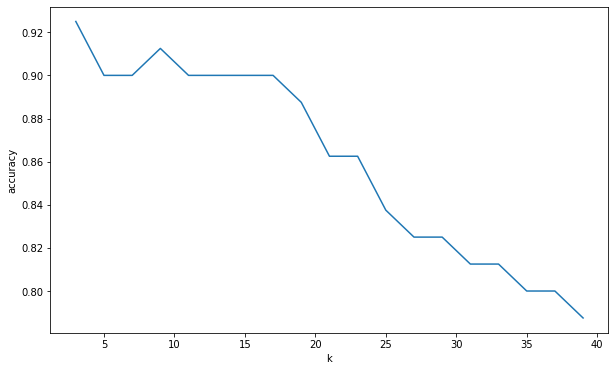

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(k_list, cross_validation_scores)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

In [14]:
# 예측율이 가장 높은 k를 선정한다.
print(cross_validation_scores)
print(max(cross_validation_scores))
optimal_k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print('최적의 k: {}'.format(optimal_k))

[0.925, 0.9, 0.9, 0.9125, 0.9, 0.9, 0.9, 0.9, 0.8875, 0.8625, 0.8625, 0.8375, 0.825, 0.825, 0.8125, 0.8125, 0.8, 0.8, 0.7875]
0.925
최적의 k: 3


최적의 k를 사용한 kNN 모델 테스트

In [15]:
# 분별력이 있다고 판단된 3P, TRB, BLK 속성(피쳐)으로 모델을 학습시킨 후 테스트를 진행한다.
knn = KNeighborsClassifier(n_neighbors=optimal_k)
# 모델 학습에 사용할 속성(피쳐)와 결과(실제값, 레이블, 타겟)를 지정한다.
x_train = train[['3P', 'TRB', 'BLK']]
y_train = train['Pos']
# 모델을 학습시킨다.
knn.fit(x_train, y_train.values.ravel())

# 모델 테스트에 사용할 속성(피쳐)와 결과(실제값, 레이블, 타겟)를 지정한다.
x_test = test[['3P', 'TRB', 'BLK']]
y_test = test['Pos']

# 테스트 데이터를 사용해 예측해보고 모델의 테스트 정확도를 계산한다.
predict = knn.predict(x_test) # 테스트 데이터를 사용해서 모델의 예측값을 얻어온다.
accuracy = accuracy_score(y_test.values.ravel(), predict) # 테스트 정확도를 계산한다.
print('정확도: {:6.2%}'.format(accuracy))

정확도: 90.00%


In [16]:
comparison = pd.DataFrame({'실제값': y_test.values.ravel(), '예측값': predict})
comparison

,실제값,예측값
0,C,C
1,SG,SG
2,C,SG
3,C,C
4,C,SG
5,SG,SG
6,SG,SG
7,C,C
8,SG,SG
9,C,C


완성된 모델 사용하기

In [18]:
x = {'3P': [0, 3.9], 'BLK': [7.7, 0.3], 'TRB': [1, 0.1]}
x_test = pd.DataFrame(x)
x_test

,3P,BLK,TRB
0,0.0,7.7,1.0
1,3.9,0.3,0.1


In [19]:
y = {'Pos': ['C', 'SG']}
y_test = pd.DataFrame(y)
y_test

,Pos
0,C
1,SG


In [22]:
predict = knn.predict(x_test)
print(predict)
accuracy = accuracy_score(y_test.values.ravel(), predict)
print('정확도: {:6.2%}'.format(accuracy))
comparison = pd.DataFrame({'실제값': y_test.values.ravel(), '예측값': predict})
comparison

['C' 'SG']
정확도: 100.00%


,실제값,예측값
0,C,C
1,SG,SG
